In [43]:
import pyfpgrowth
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict

In [44]:
# ==================== Tạo dữ liệu mẫu ====================
items = ["Sữa", "Bánh mì", "Táo", "Chuối"]
num_transactions = 10
transactions = [random.sample(items, random.randint(2, 4)) for _ in range(num_transactions)]


In [45]:
# ==================== Hiển thị giao dịch dưới dạng bảng ====================
transactions_df = pd.DataFrame({"ID": [f"{i+1}" for i in range(len(transactions))],
                                "Items": [", ".join(trans) for trans in transactions]})
print(transactions_df.to_markdown(index=False, tablefmt="grid"))

+------+--------------------------+
|   ID | Items                    |
+======+==========================+
|    1 | Chuối, Táo, Sữa, Bánh mì |
+------+--------------------------+
|    2 | Chuối, Bánh mì           |
+------+--------------------------+
|    3 | Chuối, Sữa               |
+------+--------------------------+
|    4 | Sữa, Bánh mì, Chuối      |
+------+--------------------------+
|    5 | Sữa, Chuối               |
+------+--------------------------+
|    6 | Sữa, Táo, Bánh mì, Chuối |
+------+--------------------------+
|    7 | Sữa, Táo, Bánh mì, Chuối |
+------+--------------------------+
|    8 | Sữa, Chuối               |
+------+--------------------------+
|    9 | Táo, Bánh mì             |
+------+--------------------------+
|   10 | Bánh mì, Táo             |
+------+--------------------------+


In [46]:
# ==================== Đếm tần suất xuất hiện của item ====================
item_counts = defaultdict(int)
for trans in transactions:
    for item in trans:
        item_counts[item] += 1

# Sắp xếp theo thứ tự giảm dần
item_counts = dict(sorted(item_counts.items(), key=lambda x: x[1], reverse=True))
print("Item counts:", item_counts)
# ==================== Tạo bảng tần suất ====================
freq_df = pd.DataFrame(list(item_counts.items()), columns=["Item", "Frequency"])
print(freq_df.to_markdown(index=False, tablefmt="grid"))


Item counts: {'Chuối': 8, 'Sữa': 7, 'Bánh mì': 7, 'Táo': 5}
+---------+-------------+
| Item    |   Frequency |
+=========+=============+
| Chuối   |           8 |
+---------+-------------+
| Sữa     |           7 |
+---------+-------------+
| Bánh mì |           7 |
+---------+-------------+
| Táo     |           5 |
+---------+-------------+


In [47]:
# ==================== Hiển thị giao dịch dưới dạng bảng ====================
def sort_transaction(transaction, item_counts):
    return sorted(transaction, key=lambda x: -item_counts[x])

transactions_df = pd.DataFrame({
    "ID": [f"{i+1}" for i in range(len(transactions))],
    "Items": [", ".join(trans) for trans in transactions],
    "Ordered Frequent Items": [", ".join(sort_transaction(trans, item_counts)) for trans in transactions]
})
print(transactions_df.to_markdown(index=False, tablefmt="grid"))

+------+--------------------------+--------------------------+
|   ID | Items                    | Ordered Frequent Items   |
+======+==========================+==========================+
|    1 | Chuối, Táo, Sữa, Bánh mì | Chuối, Sữa, Bánh mì, Táo |
+------+--------------------------+--------------------------+
|    2 | Chuối, Bánh mì           | Chuối, Bánh mì           |
+------+--------------------------+--------------------------+
|    3 | Chuối, Sữa               | Chuối, Sữa               |
+------+--------------------------+--------------------------+
|    4 | Sữa, Bánh mì, Chuối      | Chuối, Sữa, Bánh mì      |
+------+--------------------------+--------------------------+
|    5 | Sữa, Chuối               | Chuối, Sữa               |
+------+--------------------------+--------------------------+
|    6 | Sữa, Táo, Bánh mì, Chuối | Chuối, Sữa, Bánh mì, Táo |
+------+--------------------------+--------------------------+
|    7 | Sữa, Táo, Bánh mì, Chuối | Chuối, Sữa, Bánh mì

In [48]:
# ==================== Xây dựng FP-Tree ====================
class FPTreeNode:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.link = None  # Liên kết với node cùng item
    
    def increase(self, count):
        self.count += count

class FPTree:
    def __init__(self):
        self.root = FPTreeNode("NULL", 0, None)
        self.header_table = {}

    def insert_transaction(self, transaction, count=1):
        current_node = self.root
        for item in transaction:
            if item in current_node.children:
                current_node.children[item].increase(count)
            else:
                new_node = FPTreeNode(item, count, current_node)
                current_node.children[item] = new_node
                
                if item in self.header_table:
                    last_node = self.header_table[item]
                    while last_node.link:
                        last_node = last_node.link
                    last_node.link = new_node
                else:
                    self.header_table[item] = new_node
            
            current_node = current_node.children[item]

    def build_tree(self, transactions, item_counts):
        for transaction in transactions:
            sorted_items = sort_transaction([item for item in transaction if item in item_counts], item_counts)
            self.insert_transaction(sorted_items)

# Xây dựng FP-Tree
fp_tree = FPTree()
fp_tree.build_tree(transactions, item_counts)

+------+--------------------------+--------------------------+
|   ID | Items                    | Ordered Frequent Items   |
+======+==========================+==========================+
|    1 | Chuối, Táo, Sữa, Bánh mì | Chuối, Sữa, Bánh mì, Táo |
+------+--------------------------+--------------------------+
|    2 | Chuối, Bánh mì           | Chuối, Bánh mì           |
+------+--------------------------+--------------------------+
|    3 | Chuối, Sữa               | Chuối, Sữa               |
+------+--------------------------+--------------------------+
|    4 | Sữa, Bánh mì, Chuối      | Chuối, Sữa, Bánh mì      |
+------+--------------------------+--------------------------+
|    5 | Sữa, Chuối               | Chuối, Sữa               |
+------+--------------------------+--------------------------+
|    6 | Sữa, Táo, Bánh mì, Chuối | Chuối, Sữa, Bánh mì, Táo |
+------+--------------------------+--------------------------+
|    7 | Sữa, Táo, Bánh mì, Chuối | Chuối, Sữa, Bánh mì

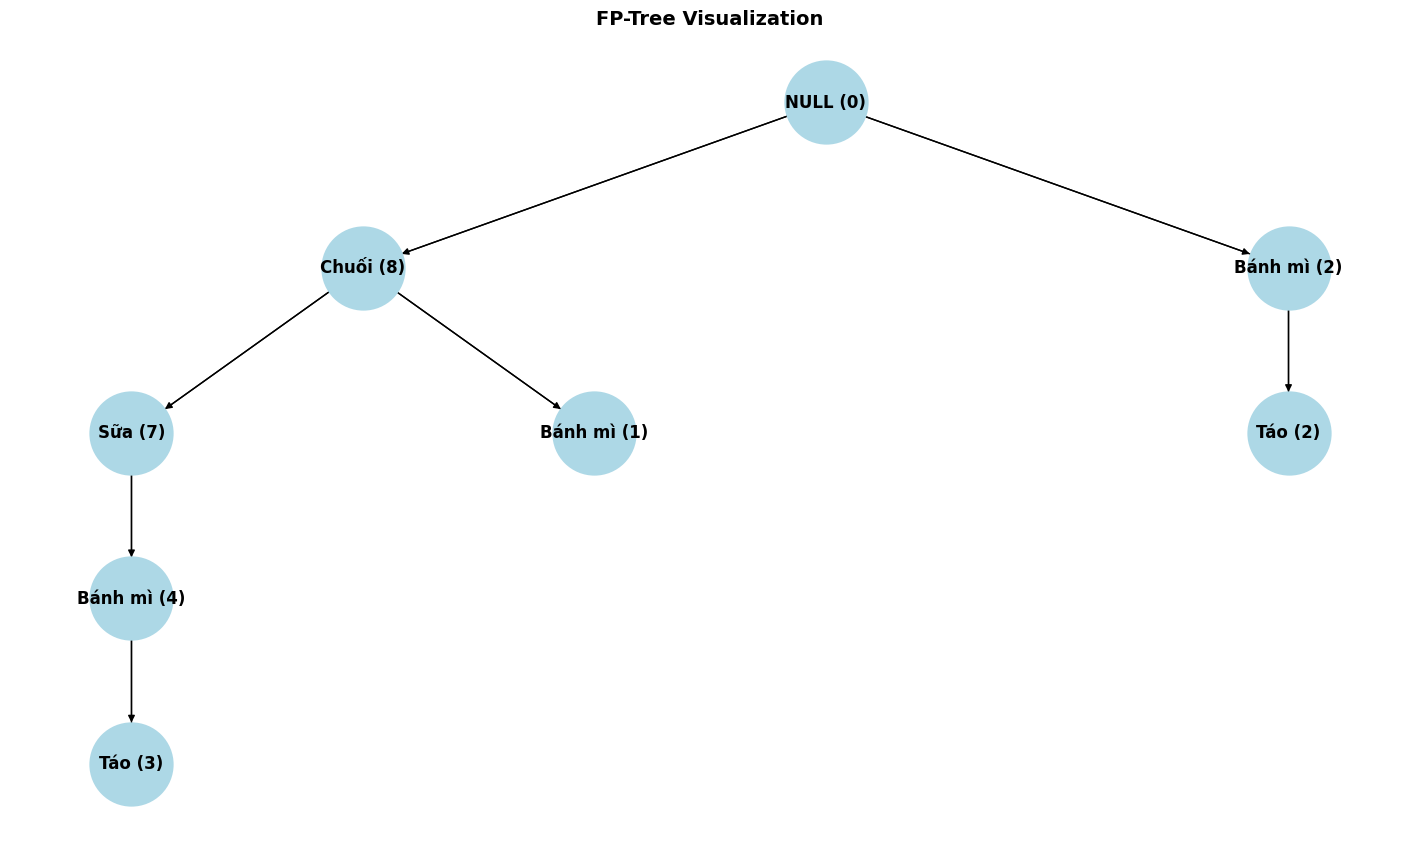

In [51]:
# ==================== Vẽ FP-Tree ====================
G = nx.DiGraph()

def add_edges(node, parent_label=None):
    label = f"{node.item} ({node.count})"
    G.add_node(label)
    if parent_label:
        G.add_edge(parent_label, label)
    
    sorted_children = sorted(node.children.values(), key=lambda x: -x.count)
    for child in sorted_children:
        add_edges(child, label)

add_edges(fp_tree.root)

# Bố trí cây phân cấp với cách đều hơn
def hierarchy_pos(G, root, width=1.5, vert_gap=0.3, xcenter=0.5, pos=None, level=0):
    if pos is None:
        pos = {root: (xcenter, 1)}
    else:
        pos[root] = (xcenter, 1 - level * vert_gap)
    
    children = list(G.successors(root))
    if not children:
        return pos
    
    dx = width / max(len(children), 1)
    nextx = xcenter - width / 2 + dx / 2
    for child in children:
        pos = hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, xcenter=nextx, pos=pos, level=level+1)
        nextx += dx
    
    return pos
print(transactions_df.to_markdown(index=False, tablefmt="grid"))
print(item_counts)
plt.figure(figsize=(14, 8))
pos = hierarchy_pos(G, root="NULL (0)")
nx.draw(G, pos, with_labels=True, node_size=3500, node_color="lightblue", edge_color="black", linewidths=1.5, font_size=12, font_weight="bold", arrows=True)
nx.draw_networkx_edges(G, pos, arrows=True, edge_color="black")
plt.title("FP-Tree Visualization", fontsize=14, fontweight="bold")
plt.show()
